Unzip the dataset copressed files in dataset. They are divided in speech and song.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

import sys
sys.path.append('../')
import default_style

TS_DATASET_FOLDER = os.path.join("..", "dataset")

SONG_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Song_Actors_01-24")
SPEECH_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Speech_Actors_01-24")

TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, "preprocessed_traces")
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, "preproc_ts.df")

def get_actor_files(vc, actor_n):
    fold = SONG_DATASET_FOLDER if vc == "song" else SPEECH_DATASET_FOLDER
    act_fold = f"Actor_{str(actor_n).zfill(2)}"
    fold = os.path.join(fold, act_fold )
    return [os.path.join(fold,f) for f in os.listdir(fold) if f.endswith(".wav")]


CATEGORICAL_FEATURES_NAMES = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}, 
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "emotional_intensity": {"01" : "normal", "02" : "strong"},
    "statement": {"01" : "kids", "02" : "dogs"},
    "repetition": {"01" : "1st", "02" : "2nd"},
    "actor": {str(i).zfill(2): str(i).zfill(2) for i in range(1, 25)}
}

SAMPLING_RATE = 48_000
DECIMATION_FACTOR = 8

def recompute_numeric_categorical(df):
    global numerical_attr_list, categorical_attr_list
    numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
    categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# File import
Files must be downsampled before being saved in memory because they are enormous (200_000 floating point numbers, roughly 0.5 MB)

In [2]:
import sys
from scipy.signal import decimate

df = pd.DataFrame(columns = list(CATEGORICAL_FEATURES_NAMES.keys()) + ["audio_trace", "path"])
for vc in ["speech", "song"]:
    for actor_n in tqdm(range(1,5)):
        for f in get_actor_files(vc, actor_n):
            segment, sr = librosa.load(f, sr=None)
            segment = decimate(segment, q=DECIMATION_FACTOR)

            categ_values = str(os.path.basename(f)).strip(".wav").split("-")

            row = {attr:val for attr, val in zip(CATEGORICAL_FEATURES_NAMES.keys(), categ_values)}
            row["audio_trace"] = [segment]
            row["path"] = f
            row = pd.DataFrame(row, index = [0])
            df = pd.concat([df,  row], ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
for column in df.columns:
    df = df.replace(CATEGORICAL_FEATURES_NAMES)

df["sex"] = ["F" if i % 2 == 0 else "M" for i in df["actor"].astype(int)]
df = df.replace({ "actor": {str(i).zfill(2): f"actor_{str(i).zfill(2)}" for i in range(1, 25)}})
df = df.drop(columns = ["modality"])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M


## Preprocessing

### trimming

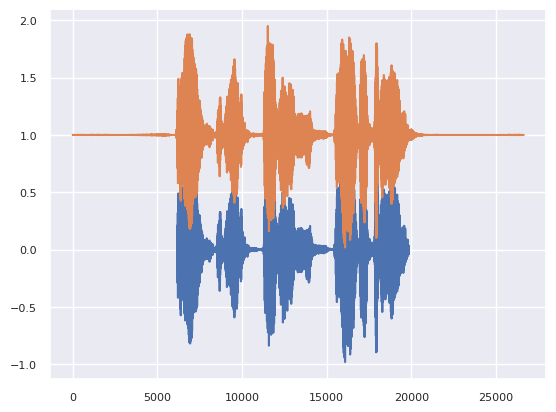

In [4]:
def trim_silence(track, window_in_ms=10.0, rel_thr=1e-2):
    ts = pd.Series(track)
    window = int(window_in_ms*1e-3*SAMPLING_RATE/DECIMATION_FACTOR )
    rolling_std = ts.rolling(window=window).std()
    mask = rolling_std > rel_thr*rolling_std.max()
    begin, end = np.where(mask)[0][0], np.where(mask)[0][-1]
    return track[begin:end], begin, end

trimmed, begin, end = trim_silence(df["audio_trace"][50],  rel_thr=5e-2)
plt.plot(np.arange(begin, end), trimmed)
plt.plot(df["audio_trace"][50] + 1)

So it seems to work. Now add to the dataset the trimmed tracks

In [5]:
trimmed_df = pd.DataFrame(columns=["trimmed_trace", "begin_s", "end_s"])
for tr in df.audio_trace:
    trimmed, begin, end = trim_silence(tr, rel_thr=5e-2)
    row = dict( trimmed_trace=[trimmed], 
                begin_s=begin/SAMPLING_RATE*DECIMATION_FACTOR, 
                end_s=end/SAMPLING_RATE*DECIMATION_FACTOR)
    row = pd.DataFrame(row, index=[0])
    trimmed_df = pd.concat([trimmed_df, row], ignore_index=True)

try:
    df.drop(columns=["trimmed_trace", "begin_s", "end_s"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(trimmed_df)

"['trimmed_trace', 'begin_s', 'end_s'] not found in axis"


check if the distribution of start time/ end time is related to actors' reactivity

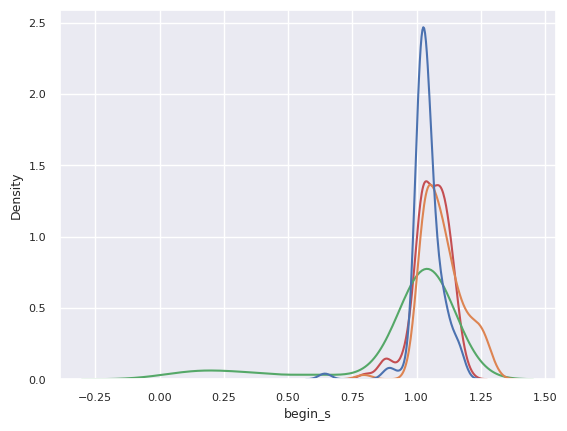

In [6]:
sns.kdeplot(data =df, x="begin_s", hue="actor", legend=False);


### Detrending

In [7]:
# First check if relevant linear trend is present
from sklearn.linear_model import LinearRegression
coeffs, intercepts = [], []
for trace in df.trimmed_trace:
    subsamp_trace = decimate(trace, q=8)
    model = LinearRegression()
    model.fit(np.arange(len(subsamp_trace)).reshape(-1,1), subsamp_trace)
    coeffs.append(model.coef_)
    intercepts.append(model.intercept_)
print(np.mean(coeffs), np.mean(intercepts))

-7.32702831088564e-09 4.93104802403281e-06


In [8]:
from scipy.signal import detrend
detrended_traces = pd.DataFrame(columns=["detrended_trace"])
for trace in df.trimmed_trace:
    row = dict(detrended_trace=[detrend(trace)])
    row = pd.DataFrame(row, index=[0])
    detrended_traces = pd.concat([detrended_traces, row], ignore_index=True)
    
try:
    df.drop(columns=["detrended_trace"], inplace=True)
except KeyError as e:
    print(e)
    pass
df = df.join(detrended_traces)

"['detrended_trace'] not found in axis"


### Amplitude Normalization

In [9]:
normalized_traces = pd.DataFrame(columns = ["normalized_trace"])
for det_trace in df.detrended_trace:
    row = dict(normalized_trace=[(det_trace - np.mean(det_trace))/np.std(det_trace)])
    row = pd.DataFrame(row, index=[0])
    normalized_traces = pd.concat([normalized_traces, row], ignore_index=True)
try:
    df.drop(columns=["normalized_trace"], inplace=True)
except KeyError as e:
    print(e)
    pass
df = df.join(normalized_traces)

"['normalized_trace'] not found in axis"


### Denoising (is it done right?)

In [10]:
denoised_traces = pd.DataFrame(columns=["denoised_trace"])
window=20
for norm_trace in df.normalized_trace:
    row = pd.DataFrame([[np.convolve(norm_trace, np.ones(window)/window, mode='valid')]], index=[0], columns=["denoised_trace"])
    denoised_traces = pd.concat([denoised_traces, row], ignore_index=True)

try:
    df.drop(columns=["denoised_trace"], inplace=True)
except KeyError as e:
    pass

df = df.join(denoised_traces)

recompute the numerical attribute list

In [11]:
recompute_numeric_categorical(df)

now check the difference in terms of perceived audio

In [12]:
Audio(df.audio_trace[58], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [13]:
Audio(df.denoised_trace[51], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [14]:
print(f"dataset size is {sys.getsizeof(df)/1e6} MB")

dataset size is 62.959936 MB


## Phonetic traces
Let's call the phonetic traces of the track the corase-grained properties of the audio track, that could correspond for example to the glottological properties of the sound particle(fricative, nasal, plosive, etc).
Check if there is some sort of difference between the "kids" statement and the "dogs" statement, even if they are rythmically equivalent.

Maybe a good starting point could be the clustering of the tracks using dtw distance on these coarse-grained timeseries.

1709


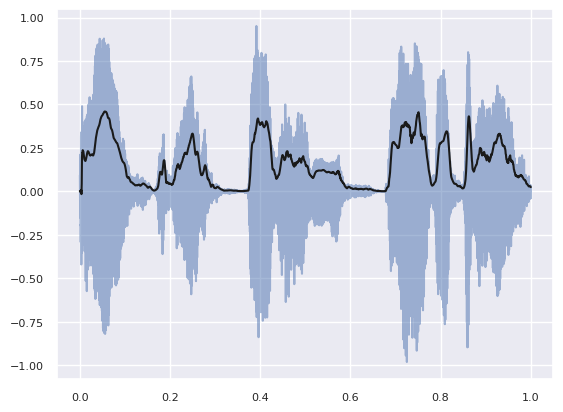

In [15]:
window_in_ms = 10.0 # Big window, is it coherent with the timescale of sound particles?
window = int(window_in_ms*1e-3*SAMPLING_RATE/DECIMATION_FACTOR )
track_N = 50

rolled_signal = pd.Series(df.trimmed_trace[track_N]).rolling(window=window).std().fillna(0)
phonetic_signal = decimate(rolled_signal,q=8) #GIGA downsampling
print(len(phonetic_signal))
plt.plot(np.linspace(0,1,len(df.trimmed_trace[track_N])), df.trimmed_trace[track_N], alpha=0.5)
plt.plot(np.linspace(0,1,len(phonetic_signal)), phonetic_signal, color="k")


clearly the timeseries must be renormalized. I choose a minmaxscaler.

In [16]:
def get_window_from_ms(window_in_ms, true_sampling_rate):
    return int(window_in_ms*1e-3*true_sampling_rate )
window = get_window_from_ms(10.0, SAMPLING_RATE/DECIMATION_FACTOR )
downsampling_factor = 8

phonetic_traces = pd.DataFrame(columns=["phonetic_trace"])
ph_traces_lengths = []

for trim_trace in df.trimmed_trace:
    rolled_signal = pd.Series(trim_trace).rolling(window=window).std().fillna(0)
    phonetic_signal = decimate(rolled_signal,q=downsampling_factor)
    ph_traces_lengths.append(len(phonetic_signal))
    row = pd.DataFrame([[phonetic_signal]],columns=["phonetic_trace"], index=[0])
    phonetic_traces = pd.concat([phonetic_traces, row], ignore_index=True)
    
try:
    df.drop(columns=["phonetic_trace"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(phonetic_traces)
recompute_numeric_categorical(df)

"['phonetic_trace'] not found in axis"


In [17]:
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex,trimmed_trace,begin_s,end_s,detrended_trace,normalized_trace,denoised_trace,phonetic_trace
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-0.0066078934, -0.0053929035, -0.0068231844, ...",1.061167,2.701833,"[-0.006622227, -0.0054072333, -0.0068375105, -...","[-0.557499, -0.45521352, -0.57562286, -0.46521...","[0.10605194792151451, 0.20370448753237724, 0.2...","[0.0001072799823350019, -9.967145683714988e-05..."
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-0.0015329155, -0.0014707618, -0.0024713622, ...",1.020167,2.983000,"[-0.0015344787, -0.0014723251, -0.0024729255, ...","[-0.32997555, -0.31660995, -0.5317799, -0.3343...","[-0.06948496256954968, -0.0633231141138822, -0...","[1.4945874906571407e-05, -1.4289939718277007e-..."
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.0056200726, 0.0055728285, 0.0049285553, 0.0...",1.057000,2.642500,"[0.0056278706, 0.005580625, 0.00493635, 0.0043...","[0.40640333, 0.40299162, 0.35646683, 0.3152057...","[-0.33900629878044125, -0.3458889901638031, -0...","[0.00014077717395704392, -0.000119171828049296..."
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.004190071, 0.005915556, 0.006408625, 0.0069...",1.068500,2.294667,"[0.0041828523, 0.0059083384, 0.0064014075, 0.0...","[0.60268354, 0.85129905, 0.9223426, 0.9972808,...","[0.23809453230351205, 0.1599859623238444, 0.06...","[7.637251972337998e-05, -6.591139617723613e-05..."
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.0008153934, -0.00020550459, -0.00069677294,...",1.023667,2.534167,"[0.0008153318, -0.00020556645, -0.00069683505,...","[0.18345565, -0.046253964, -0.15679301, -0.208...","[-0.010016298759728672, -0.022690204624086625,...","[3.4952210036188766e-06, -3.1078329731890986e-..."


Now standardise the length of the phonetic_signal. This is done by mapping each array in a fixed-length array. This length M is chosen to be the minimum of the lengths.
The map is done by selecting uniformly M integers from the interval (0, len(trace))

In [18]:
from sklearn.preprocessing import MinMaxScaler

time_rescale  = True
if time_rescale:
    std_len = min(2000, np.min(ph_traces_lengths))
    print(f"standard_lenght is set to {std_len}")
    
standardised_phonetic_traces = pd.DataFrame(columns=["std_phon_trace", "t_rescale_factor"])
for tr,trimmed_tr in zip(df.phonetic_trace,df.trimmed_trace):
    
    # Generates the downsampling indexes
    if time_rescale:
        indexes = (len(tr)-1)*(np.linspace(0,1,std_len))
        indexes = indexes.astype(int)
        time_rescale_factor = len(trimmed_tr)/std_len

        # Check repeated values
        indexes, counts = np.unique(indexes, return_counts=True)
        if (counts>1).any():
            print("repeated index")
    else:
        indexes = np.arange(len(tr))
        
    # Scales the signal here
    phonetic_signal = MinMaxScaler().fit_transform(tr[indexes].reshape(-1,1)).reshape(-1)
    row = pd.DataFrame([[phonetic_signal, time_rescale_factor]], columns=["std_phon_trace", "t_rescale_factor"], index=[0])
    standardised_phonetic_traces = pd.concat([standardised_phonetic_traces, row], ignore_index=True)

try:
    df.drop(columns=["std_phon_trace", "t_rescale_factor"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(standardised_phonetic_traces)
recompute_numeric_categorical(df)

standard_lenght is set to 846
repeated index
"['std_phon_trace', 't_rescale_factor'] not found in axis"


In [19]:
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex,trimmed_trace,begin_s,end_s,detrended_trace,normalized_trace,denoised_trace,phonetic_trace,std_phon_trace,t_rescale_factor
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-0.0066078934, -0.0053929035, -0.0068231844, ...",1.061167,2.701833,"[-0.006622227, -0.0054072333, -0.0068375105, -...","[-0.557499, -0.45521352, -0.57562286, -0.46521...","[0.10605194792151451, 0.20370448753237724, 0.2...","[0.0001072799823350019, -9.967145683714988e-05...","[0.013940394244055389, 0.007407664197544336, 0...",11.635934
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-0.0015329155, -0.0014707618, -0.0024713622, ...",1.020167,2.983000,"[-0.0015344787, -0.0014723251, -0.0024729255, ...","[-0.32997555, -0.31660995, -0.5317799, -0.3343...","[-0.06948496256954968, -0.0633231141138822, -0...","[1.4945874906571407e-05, -1.4289939718277007e-...","[0.009974278221053729, 0.007241430387805687, 0...",13.920804
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.0056200726, 0.0055728285, 0.0049285553, 0.0...",1.057000,2.642500,"[0.0056278706, 0.005580625, 0.00493635, 0.0043...","[0.40640333, 0.40299162, 0.35646683, 0.3152057...","[-0.33900629878044125, -0.3458889901638031, -0...","[0.00014077717395704392, -0.000119171828049296...","[0.020073877923817943, 0.011032406230350988, 0...",11.244681
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.004190071, 0.005915556, 0.006408625, 0.0069...",1.068500,2.294667,"[0.0041828523, 0.0059083384, 0.0064014075, 0.0...","[0.60268354, 0.85129905, 0.9223426, 0.9972808,...","[0.23809453230351205, 0.1599859623238444, 0.06...","[7.637251972337998e-05, -6.591139617723613e-05...","[0.03561628313790302, 0.028496031091708902, 0....",8.696217
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.0008153934, -0.00020550459, -0.00069677294,...",1.023667,2.534167,"[0.0008153318, -0.00020556645, -0.00069683505,...","[0.18345565, -0.046253964, -0.15679301, -0.208...","[-0.010016298759728672, -0.022690204624086625,...","[3.4952210036188766e-06, -3.1078329731890986e-...","[0.0029766544920639855, 0.002423663589946148, ...",10.712766


## Division in syllables
As a test, I try to divide the signal into adaptive windows corresponding to the syllables

- kidz-a-taw-kin-by-the-doo
- dogz-a-sit-ting-by-the-doo


In [20]:
%load_ext autoreload
%autoreload 2

from phonetic_stuff import PhoneticList, SyllablesDivider

In [21]:
# Iniializes the phonetic list
ph_list = PhoneticList.from_tracks(df.denoised_trace, 
                                   [SAMPLING_RATE/DECIMATION_FACTOR]*len(df), 
                                   17.0, # This is the time window of smoothing
                                   decimate=2)

# Defines the syllable divider
divider = SyllablesDivider(min_size_ms=8.0, 
                           smoothing_window_ms=20.0,
                           n_syllables=7,
                           #derivative_threshold=0.12 #deprecated
                          )

start_indexes, start_times = divider.get_start_points(ph_list, return_times=True, endpoint=True)

  0%|          | 0/416 [00:00<?, ?it/s]

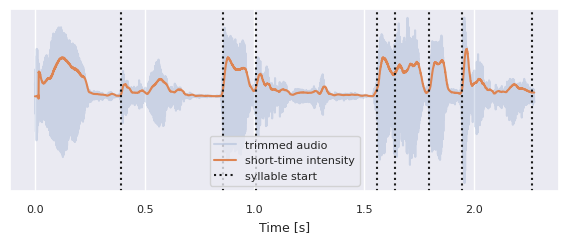

In [22]:
# Plots for a test track
test_track_index = 50

original_audio = df.denoised_trace[test_track_index]
original_time = np.linspace(0, len(original_audio)/(SAMPLING_RATE/DECIMATION_FACTOR), len(original_audio))

fig, ax = plt.subplots(figsize=default_style.SHORT_FULLSIZE_FIGURE)

ax.plot(original_time, original_audio, alpha=0.2, label="trimmed audio")
ax.plot(ph_list.elements[test_track_index].time,ph_list.elements[test_track_index].track, label="short-time intensity")

flag = False
for st in start_times[test_track_index]:
    ax.axvline(st, color="k", ls=":", label="syllable start" if not flag else "")
    flag=True
ax.set_xlabel("Time [s]")
ax.set_yticks([])
plt.legend()
plt.savefig("../images/timeseries_syllables.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


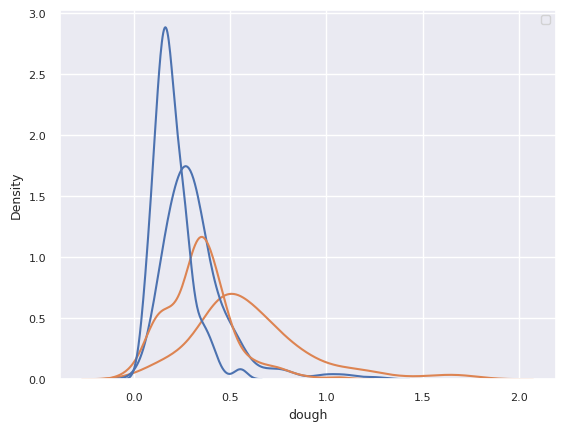

In [23]:
# Some stats of the syllables
syllables = ["bugs", "a", "ta", "ping", "by", "da", "dough"]
start_times = np.array(start_times)
u = np.diff(start_times, axis=-1)

syll_duration_df = pd.DataFrame(u, columns=syllables)
syll_duration_df = syll_duration_df.join(df[categorical_attr_list])
sns.kdeplot(data=syll_duration_df, x="dough", hue="vocal_channel")
sns.kdeplot(data=syll_duration_df, x="by", hue="vocal_channel")

plt.legend()
# plt.yscale("log")

In [24]:
# Splits the original track in syllables
syll_index = np.array(divider.get_start_points(ph_list))
syllables_df = pd.DataFrame(columns=[f"syll_{i}_start_index" for i in range(syll_index.shape[1])])

for i in range(len(ph_list)):
    row = dict()
    for syll_j in range(syll_index.shape[1]):
        row[f"syll_{syll_j}_start_index"] = ph_list[i].get_index_in_original_audio(syll_index[i][syll_j])
    row = pd.DataFrame(row, index=[0])
    syllables_df = pd.concat([syllables_df, row], ignore_index=True)

try:
    df.drop(columns=[f"syll_{i}_start_index" for i in range(syll_index.shape[1])], inplace=True)
except KeyError as e:
    print(e)


df = df.join(syllables_df)


  0%|          | 0/416 [00:00<?, ?it/s]

"['syll_0_start_index', 'syll_1_start_index', 'syll_2_start_index', 'syll_3_start_index', 'syll_4_start_index', 'syll_5_start_index', 'syll_6_start_index'] not found in axis"


## Save

In [29]:
df_to_save = df.copy()

In [30]:
# Standardizes the arrays
import awkward as ak

def pad_X(X, m_max, nan_value=0):
    return ak.fill_none(ak.pad_none(X, m_max, axis=2, clip=True), value=nan_value)

trace_cols = [col for col in df_to_save.columns if col.endswith("trace")]

for col in trace_cols:
    X = df[col].values

    # find the max length of X_train
    maximum = 0
    for ts in X:
        length = len(np.asarray(np.ravel(ts)))
        if length > maximum:
            maximum = length
    print(col, maximum)
    
    Y = np.zeros((len(X), maximum))
    for i in range(len(X)):
        Y[i] = np.pad(X[i],
                      (0, maximum - len(X[i])),
                     constant_values=(np.nan, np.nan))
    np.save(os.path.join(TS_PREPROC_FOLDER, f"{col}.npy"), Y)

audio_trace 36637
trimmed_trace 23648
detrended_trace 23648
normalized_trace 23648
denoised_trace 23629
phonetic_trace 2956
std_phon_trace 846


In [31]:
df_to_save.drop(columns=[c for c in df_to_save.columns if c.endswith("trace")], inplace=True)
df_to_save.to_csv(DF_PREPROC_FILE)